In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time, datetime

import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Load Data

In [3]:
data_dir = '/mnt/disk2/data/private_data/SSM/2_Mockup/1_AE_Accel_Data/1_Die_Fixture/Acceleration'

os.listdir(data_dir)

['bad_die_accel_test.npy',
 'bad_die_accel_train.npy',
 'good_die_accel_test.npy',
 'good_die_accel_train.npy']

In [4]:
for i in os.listdir(data_dir):
    if 'good' in i and 'train' in i:
        G_train_X = np.load(os.path.join(data_dir, i))
    elif 'bad' in i and 'train' in i:
        B_train_X = np.load(os.path.join(data_dir, i))

In [5]:
G_train_X.shape, B_train_X.shape

((2822, 40, 40), (2510, 40, 40))

In [6]:
def add_ch(img):
    """
    (sample #, height, width,) -> (sample #, height, width, channel)
    """
    return np.expand_dims(img, axis = -1)

G_train_X = add_ch(G_train_X)
B_train_X = add_ch(B_train_X)

G_train_X.shape, B_train_X.shape

((2822, 40, 40, 1), (2510, 40, 40, 1))

In [7]:
def input_for_Pytorch(img):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    img = np.transpose(img, (0, 3, 1, 2))
    return img

G_train_X = input_for_Pytorch(G_train_X)
B_train_X = input_for_Pytorch(B_train_X)

G_train_X.shape, B_train_X.shape

((2822, 1, 40, 40), (2510, 1, 40, 40))

In [8]:
def CreateLabel(data, cls):
    label = cls*np.ones([data.shape[0]])
    return label

G_train_Y, B_train_Y = CreateLabel(G_train_X, 0), CreateLabel(B_train_X, 1)

G_train_X.shape, G_train_Y.shape, B_train_X.shape, B_train_Y.shape

((2822, 1, 40, 40), (2822,), (2510, 1, 40, 40), (2510,))

In [9]:
def train_valid_split(data, label, rate_t_v = 0.9):
    data_num = len(data)
    train_idx = np.random.choice(data_num, int(rate_t_v*data_num), replace = False)
    valid_idx = np.setdiff1d(np.arange(data_num), train_idx)
    return data[train_idx], label[train_idx], data[valid_idx], label[valid_idx]

G_train_X, G_train_Y, G_valid_X, G_valid_Y = train_valid_split(G_train_X, G_train_Y)
B_train_X, B_train_Y, B_valid_X, B_valid_Y = train_valid_split(B_train_X, B_train_Y)

print("Training:", G_train_X.shape, G_train_Y.shape, B_train_X.shape, B_train_Y.shape)
print("Validation:", G_valid_X.shape, G_valid_Y.shape, B_valid_X.shape, B_valid_Y.shape)

Training: (2539, 1, 40, 40) (2539,) (2259, 1, 40, 40) (2259,)
Validation: (283, 1, 40, 40) (283,) (251, 1, 40, 40) (251,)


# Model

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # RGB세개 1채널, 20개 특징 추출, filter 크기, stride 1
        self.conv1_1 = nn.Conv2d(1, 64, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.conv4_1 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        self.dense1 = nn.Linear(2*2*64, 128)
        # 0.5 가 권장 할 만하대
        self.dropout1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128, 2)  
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_bn(self.conv1_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_bn(self.conv2_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_bn(self.conv3_2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_bn(self.conv4_2(x)))
        x = F.max_pool2d(x, 2, 2)
        # flatten
        x = x.view(-1, 2*2*64)
        x = F.relu(self.dense1(x))
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

In [11]:
model = ConvNet()
# model = model.cuda()
model = model.to(device)
# if device == 'cuda':
#     net = torch.nn.DataParallel(net)
#     cudnn.benchmark = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

summary(model, (1, 40, 40), device = device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 40, 40]             640
            Conv2d-2           [-1, 64, 40, 40]          36,928
       BatchNorm2d-3           [-1, 64, 40, 40]             128
            Conv2d-4           [-1, 64, 20, 20]          36,928
            Conv2d-5           [-1, 64, 20, 20]          36,928
       BatchNorm2d-6           [-1, 64, 20, 20]             128
            Conv2d-7           [-1, 64, 10, 10]          36,928
            Conv2d-8           [-1, 64, 10, 10]          36,928
       BatchNorm2d-9           [-1, 64, 10, 10]             128
           Conv2d-10             [-1, 64, 5, 5]          36,928
           Conv2d-11             [-1, 64, 5, 5]          36,928
      BatchNorm2d-12             [-1, 64, 5, 5]             128
           Linear-13                  [-1, 128]          32,896
          Dropout-14                  [

(tensor(292802), tensor(292802))

# Training

In [12]:
def RandomMinibatch(data, label, n_batch = 100):
    batch_idx = np.random.choice(len(data), n_batch, replace = False)
    return data[batch_idx], label[batch_idx]

G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)

G_valid_x, G_valid_y = RandomMinibatch(G_valid_X, G_valid_Y, 100)
B_valid_x, B_valid_y = RandomMinibatch(B_valid_X, B_valid_Y, 100)

print("Training:", G_train_x.shape, G_train_y.shape, B_train_x.shape, B_train_y.shape)
print("Validation:", G_valid_x.shape, G_valid_y.shape, B_valid_x.shape, B_valid_y.shape)

Training: (100, 1, 40, 40) (100,) (100, 1, 40, 40) (100,)
Validation: (100, 1, 40, 40) (100,) (100, 1, 40, 40) (100,)


In [13]:
def shuffle(x, y):
    """
    random shuffle of two paired data -> x, y = shuffle(x, y)
    but, available of one data -> x = shuffle(x, None)
    """
    idx = np.arange(len(x))
    np.random.shuffle(idx)
    if type(x) == type(y):
        return x[idx], y[idx] 
    else:
        return x[idx]
    
G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)
    
train_x, train_y = np.vstack([G_train_x, B_train_x]), np.hstack([G_train_y, B_train_y])
train_x, train_y = shuffle(train_x, train_y)

print("Training", train_x.shape, train_y.shape)

Training (200, 1, 40, 40) (200,)


In [14]:
loss_history, accr_history = [], []
val_loss_history, val_accr_history = [], []

iter_i = 0

while True:
    iter_i += 1
    
    G_train_x, G_train_y = RandomMinibatch(G_train_X, G_train_Y, 100)
    B_train_x, B_train_y = RandomMinibatch(B_train_X, B_train_Y, 100)
    
    train_x, train_y = np.vstack([G_train_x, B_train_x]), np.hstack([G_train_y, B_train_y])

    train_x, train_y = shuffle(train_x, train_y)
    
#     train_x, train_y = train_x.to(device), train_y.to(device)
    train_x, train_y = torch.tensor(train_x, device=device).float(), torch.tensor(train_y, device=device).long()
    
    output = model(train_x)
    loss = criterion(output, train_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if iter_i % 10 == 0:
        
        _, pred = torch.max(output, 1)
        
        loss_history.append(loss.tolist())
        accr_history.append((torch.sum(pred == train_y.data).tolist() / len(train_y)))
        
        with torch.no_grad():
    
            G_valid_x, G_valid_y = RandomMinibatch(G_valid_X, G_valid_Y, 100)
            B_valid_x, B_valid_y = RandomMinibatch(B_valid_X, B_valid_Y, 100)

            valid_x, valid_y = np.vstack([G_valid_x, B_valid_x]), np.hstack([G_valid_y, B_valid_y])
#             valid_x, valid_y = valid_x.to(device), valid_y.to(device)
            valid_x, valid_y = torch.tensor(valid_x, device=device).float(), torch.tensor(valid_y, device=device).long()

            valid_output = model(valid_x)
            valid_loss = criterion(valid_output, valid_y)
            
            _, valid_pred = torch.max(valid_output, 1)
        
            val_loss_history.append(valid_loss.tolist())
            val_accr_history.append((torch.sum(valid_pred == valid_y.data).tolist() / len(valid_y)))
        
        
        print("{:05d} | train_loss: {:.5f}, train_accr: {:.3f} | val_loss: {:.5f}, val_accr: {:.3f}".format(iter_i, 
                                                                                                            loss_history[-1], 
                                                                                                            accr_history[-1], 
                                                                                                            val_loss_history[-1], 
                                                                                                            val_accr_history[-1]))
        
        if iter_i >= 100:  
#             if np.mean(val_loss_history[-5 :]) >= np.mean(val_loss_history[-10:]):
#                 print('')
#                 print('Early stopping!!')
#                 print('..val_loss (avg. within 5): {:.5f} >= val_loss (avg. within 10) {:.5f}'.format(np.mean(val_loss_history[-5 :]),
#                                                                                                   np.mean(val_loss_history[-10:])))
                
            if val_loss_history[-1] == np.min(val_loss_history):

                now = datetime.datetime.now()
                nowDatetime = now.strftime('%y%m%d%H%M')
                model_name = 'Accel_GB_{}_{:05d}_loss_{:.6f}_val_loss_{:.6f}.pt'.format(nowDatetime, iter_i, 
                                                                                     np.mean(loss_history[-3:]),
                                                                                     np.mean(val_loss_history[-3:]))
                torch.save(model.state_dict(), './model/' + model_name)
#                 break                   
        if iter_i == 5000:
            break

00010 | train_loss: 0.67050, train_accr: 0.605 | val_loss: 0.65844, val_accr: 0.615
00020 | train_loss: 0.63513, train_accr: 0.630 | val_loss: 0.65375, val_accr: 0.610
00030 | train_loss: 0.61480, train_accr: 0.700 | val_loss: 0.62148, val_accr: 0.650
00040 | train_loss: 0.61699, train_accr: 0.695 | val_loss: 0.62666, val_accr: 0.665
00050 | train_loss: 0.60183, train_accr: 0.725 | val_loss: 0.61379, val_accr: 0.705
00060 | train_loss: 0.62331, train_accr: 0.670 | val_loss: 0.60939, val_accr: 0.715
00070 | train_loss: 0.57639, train_accr: 0.715 | val_loss: 0.59976, val_accr: 0.705
00080 | train_loss: 0.56486, train_accr: 0.735 | val_loss: 0.55861, val_accr: 0.745
00090 | train_loss: 0.52479, train_accr: 0.790 | val_loss: 0.58256, val_accr: 0.665
00100 | train_loss: 0.55136, train_accr: 0.745 | val_loss: 0.55583, val_accr: 0.780
00110 | train_loss: 0.52465, train_accr: 0.800 | val_loss: 0.53243, val_accr: 0.785
00120 | train_loss: 0.51669, train_accr: 0.775 | val_loss: 0.50543, val_accr

00990 | train_loss: 0.00789, train_accr: 1.000 | val_loss: 0.03889, val_accr: 0.990
01000 | train_loss: 0.00753, train_accr: 1.000 | val_loss: 0.02797, val_accr: 0.995
01010 | train_loss: 0.00793, train_accr: 1.000 | val_loss: 0.00818, val_accr: 1.000
01020 | train_loss: 0.01166, train_accr: 1.000 | val_loss: 0.00960, val_accr: 1.000
01030 | train_loss: 0.00611, train_accr: 1.000 | val_loss: 0.02100, val_accr: 0.995
01040 | train_loss: 0.00581, train_accr: 1.000 | val_loss: 0.02504, val_accr: 0.995
01050 | train_loss: 0.00458, train_accr: 1.000 | val_loss: 0.00941, val_accr: 1.000
01060 | train_loss: 0.00406, train_accr: 1.000 | val_loss: 0.00772, val_accr: 1.000
01070 | train_loss: 0.00565, train_accr: 1.000 | val_loss: 0.01175, val_accr: 1.000
01080 | train_loss: 0.00490, train_accr: 1.000 | val_loss: 0.02170, val_accr: 0.995
01090 | train_loss: 0.00555, train_accr: 1.000 | val_loss: 0.03064, val_accr: 0.990
01100 | train_loss: 0.00330, train_accr: 1.000 | val_loss: 0.02066, val_accr

01970 | train_loss: 0.00096, train_accr: 1.000 | val_loss: 0.02189, val_accr: 0.995
01980 | train_loss: 0.00110, train_accr: 1.000 | val_loss: 0.01637, val_accr: 0.995
01990 | train_loss: 0.00088, train_accr: 1.000 | val_loss: 0.00305, val_accr: 1.000
02000 | train_loss: 0.00116, train_accr: 1.000 | val_loss: 0.01956, val_accr: 0.995
02010 | train_loss: 0.00090, train_accr: 1.000 | val_loss: 0.01487, val_accr: 0.995
02020 | train_loss: 0.00116, train_accr: 1.000 | val_loss: 0.01493, val_accr: 0.995
02030 | train_loss: 0.00085, train_accr: 1.000 | val_loss: 0.00146, val_accr: 1.000
02040 | train_loss: 0.00094, train_accr: 1.000 | val_loss: 0.01764, val_accr: 0.995
02050 | train_loss: 0.00120, train_accr: 1.000 | val_loss: 0.02157, val_accr: 0.995
02060 | train_loss: 0.00098, train_accr: 1.000 | val_loss: 0.00184, val_accr: 1.000
02070 | train_loss: 0.00096, train_accr: 1.000 | val_loss: 0.00173, val_accr: 1.000
02080 | train_loss: 0.00053, train_accr: 1.000 | val_loss: 0.01698, val_accr

02950 | train_loss: 0.00038, train_accr: 1.000 | val_loss: 0.03039, val_accr: 0.990
02960 | train_loss: 0.00049, train_accr: 1.000 | val_loss: 0.02989, val_accr: 0.990
02970 | train_loss: 0.00042, train_accr: 1.000 | val_loss: 0.02389, val_accr: 0.995
02980 | train_loss: 0.00033, train_accr: 1.000 | val_loss: 0.02685, val_accr: 0.995
02990 | train_loss: 0.00028, train_accr: 1.000 | val_loss: 0.00189, val_accr: 1.000
03000 | train_loss: 0.00042, train_accr: 1.000 | val_loss: 0.04785, val_accr: 0.990
03010 | train_loss: 0.00028, train_accr: 1.000 | val_loss: 0.00077, val_accr: 1.000
03020 | train_loss: 0.00033, train_accr: 1.000 | val_loss: 0.04061, val_accr: 0.990
03030 | train_loss: 0.00047, train_accr: 1.000 | val_loss: 0.01445, val_accr: 0.995
03040 | train_loss: 0.00036, train_accr: 1.000 | val_loss: 0.02073, val_accr: 0.995
03050 | train_loss: 0.00035, train_accr: 1.000 | val_loss: 0.01590, val_accr: 0.995
03060 | train_loss: 0.00038, train_accr: 1.000 | val_loss: 0.00090, val_accr

03930 | train_loss: 0.00015, train_accr: 1.000 | val_loss: 0.00030, val_accr: 1.000
03940 | train_loss: 0.00014, train_accr: 1.000 | val_loss: 0.00133, val_accr: 1.000
03950 | train_loss: 0.00033, train_accr: 1.000 | val_loss: 0.00038, val_accr: 1.000
03960 | train_loss: 0.00018, train_accr: 1.000 | val_loss: 0.01346, val_accr: 0.995
03970 | train_loss: 0.00019, train_accr: 1.000 | val_loss: 0.00070, val_accr: 1.000
03980 | train_loss: 0.00016, train_accr: 1.000 | val_loss: 0.01984, val_accr: 0.995
03990 | train_loss: 0.00023, train_accr: 1.000 | val_loss: 0.00021, val_accr: 1.000
04000 | train_loss: 0.00016, train_accr: 1.000 | val_loss: 0.00060, val_accr: 1.000
04010 | train_loss: 0.00016, train_accr: 1.000 | val_loss: 0.00043, val_accr: 1.000
04020 | train_loss: 0.00014, train_accr: 1.000 | val_loss: 0.00110, val_accr: 1.000
04030 | train_loss: 0.00011, train_accr: 1.000 | val_loss: 0.00052, val_accr: 1.000
04040 | train_loss: 0.00012, train_accr: 1.000 | val_loss: 0.00067, val_accr

04910 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.02184, val_accr: 0.995
04920 | train_loss: 0.00008, train_accr: 1.000 | val_loss: 0.01418, val_accr: 0.995
04930 | train_loss: 0.00010, train_accr: 1.000 | val_loss: 0.01674, val_accr: 0.995
04940 | train_loss: 0.00010, train_accr: 1.000 | val_loss: 0.02367, val_accr: 0.995
04950 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.00084, val_accr: 1.000
04960 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.01902, val_accr: 0.995
04970 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.00022, val_accr: 1.000
04980 | train_loss: 0.00009, train_accr: 1.000 | val_loss: 0.02154, val_accr: 0.995
04990 | train_loss: 0.00007, train_accr: 1.000 | val_loss: 0.01100, val_accr: 0.995
05000 | train_loss: 0.00013, train_accr: 1.000 | val_loss: 0.00009, val_accr: 1.000


/home/yunseob/Pytorch/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


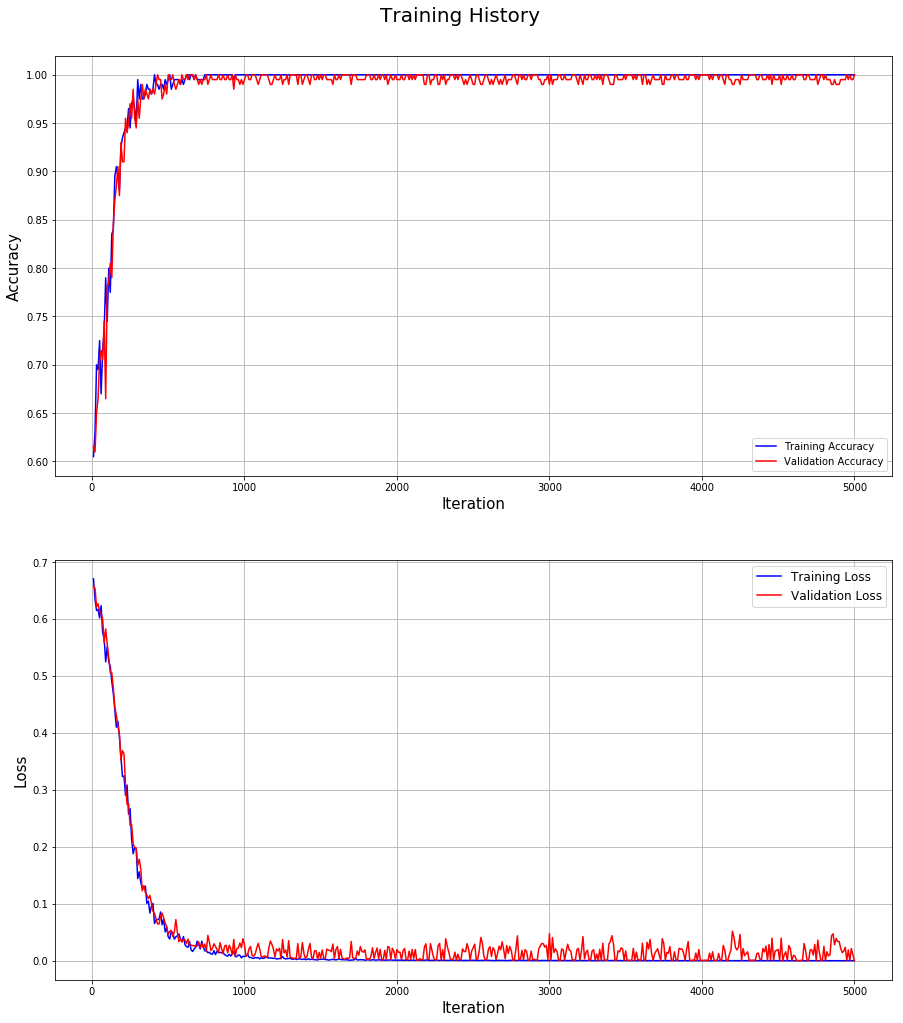

In [15]:
fig = plt.figure(figsize = (15,17))
plt.suptitle('Training History', y = 0.92, fontsize = 20)

# x_axis = range(1, 10*len(accr_history)+1, 10)
x_axis = np.arange(10, 10*len(accr_history)+1, 10)

plt.subplot(2, 1, 1)
plt.plot(x_axis, accr_history, 'b-', label = 'Training Accuracy')
plt.plot(x_axis, val_accr_history, 'r-', label = 'Validation Accuracy')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.legend(fontsize = 10)
plt.grid('on')
plt.subplot(2, 1, 2)
plt.plot(x_axis, loss_history, 'b-', label = 'Training Loss')
plt.plot(x_axis, val_loss_history, 'r-', label = 'Validation Loss')
plt.xlabel('Iteration', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
# plt.yticks(np.arange(0, 0.25, step=0.025))
plt.legend(fontsize = 12)
plt.grid('on')
plt.show()

# if save == True:
#     fig.savefig(hist_path + filename)
#     plt.close(fig)

In [16]:
np.save('./results/0_train_hist/Accel_GB_accr_history', accr_history)
np.save('./results/0_train_hist/Accel_GB_val_accr_history', val_accr_history)
np.save('./results/0_train_hist/Accel_GB_loss_history', loss_history)
np.save('./results/0_train_hist/Accel_GB_val_loss_history', val_loss_history)